
## Какой кейс решаем?

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.


Конкретно в этом ноутбуке я попробую пойти по пути минимизации входных данных - безжалостно выкидывая то, что мне кажется несущественным и не сильно влияющим на результат, или требующим слишком больших усилий по извлечению полезных данных, когда потенциальная выгода от этих данных скорее всего не будет стоить затраченных на это усилий.

Посмотрим, что получится.

ПРИМЕЧАНИЕ: Это третья версия ноутбука, где я пробую улучшить результат предыдущих попыток. В этой версии будет много вырезано (закомментировано), поскольку некоторые вещи показали себя не очень важными/влияющими на результат.
Лучший счёт, который я получил, в предидущих версиях: 13.77663

Результат этого ноутбука: MAPE: 0.1289359790914

### 0. Загрузка данных, библиотек, подготовка.

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [18]:
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn.model_selection import train_test_split # Загружаем специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели

import matplotlib.pyplot as plt
from textblob import TextBlob

In [19]:
# переменные тут
random_seed = 874
path = '/kaggle/input/sf-booking/'

In [20]:
hotels = pd.read_csv(path + 'hotels_train.csv')
hotels_test = pd.read_csv(path + 'hotels_test.csv')
sample_submission = pd.read_csv(path + 'submission.csv')

## 1. Изучение данных

In [21]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [22]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


Да, по стратегии, выбранной в начале - в этом датасете есть довольно много "лишних" данных, которые можно просто удалить, или серьезно сократить.

### 1.1 Удаление дубликатов

In [23]:
# проверим и отчистим датасет от дубликатов
print(f"Всего дубликатов: {hotels.duplicated().sum()}\n{hotels.shape}")

Всего дубликатов: 307
(386803, 17)


In [24]:
# удалим дубликаты
hotels = hotels.drop_duplicates ()
print(f"Всего дубликатов: {hotels.duplicated().sum()}\n{hotels.shape}")

Всего дубликатов: 0
(386496, 17)


пропуски данных есть только в колонках lat и lng - мы этим заниматься не будем. Все равно потом, по нашей стратегии мы эти колонки удалим.

In [25]:
# проверим, нет-ли у нас явно неверных данных
col_test = list(hotels.select_dtypes(['int64','float64']).columns)

for i in col_test:
    print('{} - min: {}, max: {}'.format(i,hotels[i].min(),hotels[i].max()))

additional_number_of_scoring - min: 1, max: 2682
average_score - min: 5.2, max: 9.8
review_total_negative_word_counts - min: 0, max: 408
total_number_of_reviews - min: 43, max: 16670
review_total_positive_word_counts - min: 0, max: 395
total_number_of_reviews_reviewer_has_given - min: 1, max: 355
reviewer_score - min: 2.5, max: 10.0
lat - min: 41.3283758, max: 52.4001813
lng - min: -0.3697581, max: 16.4292329


очевидных аномальных значений в числовых данных нет

### 1.2 Объединение тестового и тренировочного датасета

In [26]:
# Что-бы данные у нас обработались одинаково, временно объединим датасеты, и пометим, кто из них - кто.
hotels['train'] = 1 # помечаем где у нас трейн
hotels_test['train'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет столбца reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

#Deprecated
#hotels = hotels_test.append(hotels, sort=False).reset_index(drop=True) # объединяем

hotels = pd.concat([hotels,hotels_test], sort=False, ignore_index=True) # объединяем

## 2. Очистка данных. Создание новых признаков.

Первыми под нож пойдут lat и lng. Первые тесты в базовом решении показали, что их влияние на результат - крайне мало, в их данных есть пропуски, которые надо чем-то заполнить. И мне кажется, что усилия, затраченные на то, что-бы выудить какую-то полезную информацию из географических координат - не стоят того незначительного улучшения модели, которое возможно произойдёт.

In [27]:
hotels = hotels.drop(['lat','lng'], axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Далее - сами по себе обзоры текстом нам ничем не помогут. А вот количество слов - может. Причем, как мне кажется, важны не абсолютные цифры слов, а их отношение. Удалим лишние данные, и создадим два новых признака - отношение количества позитивных слов к негативным. Два - потому-что одно будет арифметическое отличие, второе - деление. Пока не знаю, какое будет сильней влиять - посмотрим потом.

Upd: предыдущие версии показали, что идея с отношением количества слов - оказалась очень удачной. Этот параметр по влиянию на модель превзошел остальные параметры более чем в два раза!!!

И вообще, идея с тем, что очень много информации можно вытащить именно из обзора - мне понравилась. Поэтому в этой версии я добавлю еще один признак, а именно - эмоциональную окраску отзыва. Из всех найденных мной вариантов - наиболее простым решением мне показалась библиотека TextBlob

In [28]:
# создадим функцию для получения полярности и объективности текста
def text_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    polarity = sentiment.polarity
    subjectivity = sentiment.subjectivity
    return polarity,subjectivity

In [29]:
polarity_subjectivity = hotels['positive_review'].apply(text_sentiment)
hotels[['positive_review_polarity', 'positive_review_subjectivity']] = polarity_subjectivity.apply(lambda x: pd.Series(x))

polarity_subjectivity = hotels['negative_review'].apply(text_sentiment)
hotels[['negative_review_polarity', 'negative_review_subjectivity']] = polarity_subjectivity.apply(lambda x: pd.Series(x))

In [30]:
hotels = hotels.drop(['positive_review','negative_review'], axis=1)

In [31]:
hotels['review_word_counts_related'] = hotels['review_total_positive_word_counts'] - hotels['review_total_negative_word_counts']
hotels['review_word_counts_related_divide'] = (hotels['review_total_positive_word_counts'] + 1) / (hotels['review_total_negative_word_counts'] + 1)
hotels['review_word_counts_related_divide'].value_counts()

1.000000    15850
7.000000     7320
6.000000     7101
0.500000     7015
8.000000     6852
            ...  
0.638554        1
0.659341        1
0.095808        1
7.352941        1
0.008427        1
Name: review_word_counts_related_divide, Length: 11368, dtype: int64

Сразу посмотрим, насколько оказывают влияние количество слов в ревью, заодно проверим предположение, что важно не количество слов, а их соотношение

<Axes: >

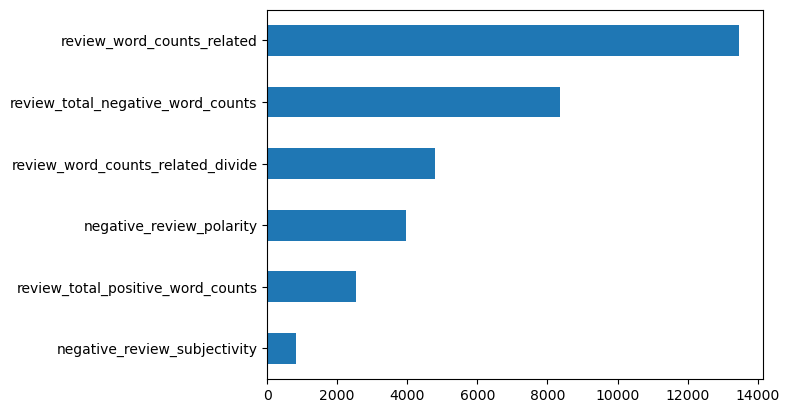

In [32]:
num_cols = ['review_total_negative_word_counts', 'review_total_positive_word_counts','review_word_counts_related','review_word_counts_related_divide','negative_review_polarity','negative_review_subjectivity']

# Теперь выделим тестовую часть
train_data = hotels.query('train == 1').drop(['train'], axis=1)
test_data = hotels.query('train == 0').drop(['train'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

#X = hotels.drop(['reviewer_score'], axis = 1)  
#y = hotels['reviewer_score'] 

y=y.astype('int')

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Подтверждается наше предположение, что отношение слов влияет больше, чем их количество. Оставим и арифметическое и деление. Потому-что потом, в разных версиях они оказывали разное влияние, и я пока не могу выбрать какое из них оставить.

In [ ]:
#hotels = hotels.drop(['review_total_positive_word_counts','review_total_negative_word_counts','review_word_counts_related_divide'], axis=1)
#hotels.info()

Следущими под нож пустим те данные, из которых я или не представляю, как получить что-то полезное, или считаю, что их влияние слишком незначительное, как нам показали предварительные непараметрические тесты. От адреса отеля тоже пока избавимся, оставим его на другие варианты. Из него можно выудить полезную информацию, но в рамках этого конкретного ноутбука с минимизацией затрат и данных - его пока выкинем. Имя отеля - в этом ноутбуке пока тоже отбросим. В конце концов, нам не столько важно имя, сколько оценка, которую ставили этому отелю другие пользователи. А именно этот параметр, по факту, мы-бы рассматривали, если-б стали учитывать имя.

В этой версии выбросим только адрес и имя отеля. Остальное оставим

In [33]:
#hotels = hotels.drop(['days_since_review','additional_number_of_scoring','days_since_review'], axis=1)
hotels = hotels.drop(['hotel_address'], axis=1) # возможно используем в следущих ноутбуках
hotels = hotels.drop(['hotel_name'], axis=1) # возможно используем в следущих ноутбуках
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   reviewer_nationality                        515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   tags                                        515431 non-null  object 
 

Побудем немного националистами, и предположим, что национальность человека влияет на то, как он, в целом, оценивает. Превратим графу "национальность" в категорию

Upd: я не увидел какого-то влияния этих данных на результат в простой обработке. Скорее всего, отсюда можно еще выудить полезную информацию, например, поездка-ли это внутрення с языком носителя, или зарубежная с незнакомым языком. Но в рамках этого ноубука мы эти данные сбросим.
Поэтому обработку данных закомментируем, столбец сбросим

In [34]:
hotels = hotels.drop(['reviewer_nationality'], axis=1)

In [ ]:
#hotels['reviewer_nationality'].value_counts()

In [ ]:
#nationality=hotels['reviewer_nationality'].value_counts().nlargest(30).index
#hotels['reviewer_nationality']=hotels['reviewer_nationality'].apply(lambda x: x if x in nationality else 'other')
#hotels['reviewer_nationality'].value_counts()

In [ ]:
#hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category') # преобразуем тип столбца
#hotels.info()

Далее - дата. Не думаю, что год, или число, как-то может повлиять на оценку, а вот время года - вполне может. Месяца будет достаточно.

In [35]:
hotels['review_month']= pd.DatetimeIndex(pd.to_datetime(hotels['review_date'])).month
hotels = hotels.drop(['review_date'], axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   tags                                        515431 non-null  object 
 8   days_since_review                           515431 non-null  object 
 9   train                                       515431 non-null  int64  
 

Последними остались теги. Хотелось-бы их сбросить, но мне кажется, что там слишком много важной информации. Стоит с ними повозиться.

Влияние тегов довольно малое при выбранной стратегии обработки. А время работы модели серьёзно увеличивает. В этот раз сокращу количество популярных тегов с 30 до 10. И отавим количество тегов.

In [37]:
# для начала чуть почистим, и приведем все теги в единый вид
hotels['tags'] = hotels['tags'].str.lower().str.replace('[','').str.replace(']','').str.replace('"','').str.replace("'",'').str.replace(' ','')
hotels['tags']

/tmp/ipykernel_32/3811178171.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  hotels['tags'] = hotels['tags'].str.lower().str.replace('[','').str.replace(']','').str.replace('"','').str.replace("'",'').str.replace(' ','')


0         leisuretrip,couple,studiosuite,stayed2nights,s...
1         businesstrip,couple,standarddoubleroom,stayed1...
2         leisuretrip,solotraveler,moderndoubleroomecho,...
3         leisuretrip,solotraveler,standardroomwith1doub...
4         businesstrip,couple,standarddoubleortwinroom,s...
                                ...                        
515426         businesstrip,couple,doubleroom,stayed4nights
515427    leisuretrip,couple,doubleroom,stayed2nights,su...
515428    businesstrip,solotraveler,singleroom,stayed2ni...
515429    leisuretrip,solotraveler,executivedoubleortwin...
515430    leisuretrip,couple,standardroomwithspaaccess,s...
Name: tags, Length: 515431, dtype: object

In [38]:
tag = hotels['tags'].str.split(',').explode()
tag.value_counts()

leisuretrip                            417538
submittedfromamobiledevice             307470
couple                                 252128
stayed1night                           193568
stayed2nights                          133850
                                        ...  
deluxeonebedroomparksuite                   1
suitewithknightsbridgeview                  1
suitewithclubloungeaccess                   1
familyroomtwoconnectingrooms3adults         1
kingmastersuite                             1
Name: tags, Length: 2412, dtype: int64

Итого, у нас 2352 уникальных тега. Это слишком много. Мне кажется, важным будет только количество тегов в оценке, и первые 20-30 тегов.

In [36]:
# создадим новый признак - количество тегов. Считаем по количеству запятых. Если запятых нет - это может быть и 1 тег, и вообще без тегов. Но количество таких записей - 70. Это не стоит того, что-бы разбираться и разделять.
hotels['tags_count'] = hotels['tags'].str.count(',') + 1
hotels['tags_count'].value_counts()

5    297661
4    211423
3      5501
6       755
2        85
1         6
Name: tags_count, dtype: int64

In [39]:
# выделим 10 наиболее часто встречающизся тегов
tag_top10=tag.value_counts().nlargest(10).index
tag_top10

Index(['leisuretrip', 'submittedfromamobiledevice', 'couple', 'stayed1night',
       'stayed2nights', 'solotraveler', 'stayed3nights', 'businesstrip',
       'group', 'familywithyoungchildren'],
      dtype='object')

In [40]:
# Создадим по бинарному столбцу для каждого тега
for i in tag_top10:
    name = 'tag_' + i
    hotels[name] = hotels['tags'].apply(lambda x: 1 if i in x else 0)
    hotels[name] = hotels[name].astype('uint8') # а то датасет разрастается втрое!

hotels = hotels.drop(['tags'], axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  object 
 8   train                                       515431 non-null  int64  
 9   positive_review_polarity                    515431 non-null  float64
 

In [42]:
#исправим days_since_review                           
hotels['days_since_review'] = hotels['days_since_review'].str.extract('(\d+)').astype('uint16')
hotels['days_since_review']

0         531
1         203
2         289
3         681
4         516
         ... 
515426    547
515427    411
515428     28
515429    586
515430    589
Name: days_since_review, Length: 515431, dtype: uint16

Напоследок, применим One-hot-encoding к последнему категориальному признаку reviewer_nationality
Очень хочется, конечно, применить Ordinal Encoding, что-бы не разрастать датафрейм, но, я погуглил, и в данном случае рекомендуется использовать O-h-e, посколько данные в категории абсолютно разные, и с соседними данными никак, даже близко, не связаны. Ordinal можно использовать, если-бы категория была-бы навроде (1=Bad,2=Poor,3=Average,4=Good,5=Excelent)

Upd: в этой вресии эту графу мы сбросили. Поэтому закомментируем

In [ ]:
#hotels = pd.get_dummies(hotels, columns=['reviewer_nationality'])
#hotels.info()

Проверяем, что всё в порядке, ничего не забыли

In [43]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  uint16 
 8   train                                       515431 non-null  int64  
 9   positive_review_polarity                    515431 non-null  float64
 

## 3. Обучение и тестирование модели

In [44]:
# Снова разделим датафрейм на тестовую и тренировочную часть

# выделим тестовую часть
train_data = hotels.query('train == 1').drop(['train'], axis=1)
test_data = hotels.query('train == 0').drop(['train'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
#X = hotels.drop(['reviewer_score'], axis = 1)  
#y = hotels['reviewer_score'] 

In [45]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

In [46]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100,
                             n_jobs=-1,
                             random_state=random_seed)
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [47]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1289359790914


MAPE: 0.1289359790914

Отлично! Это мой лучший результат. Сохраним его.

<Axes: >

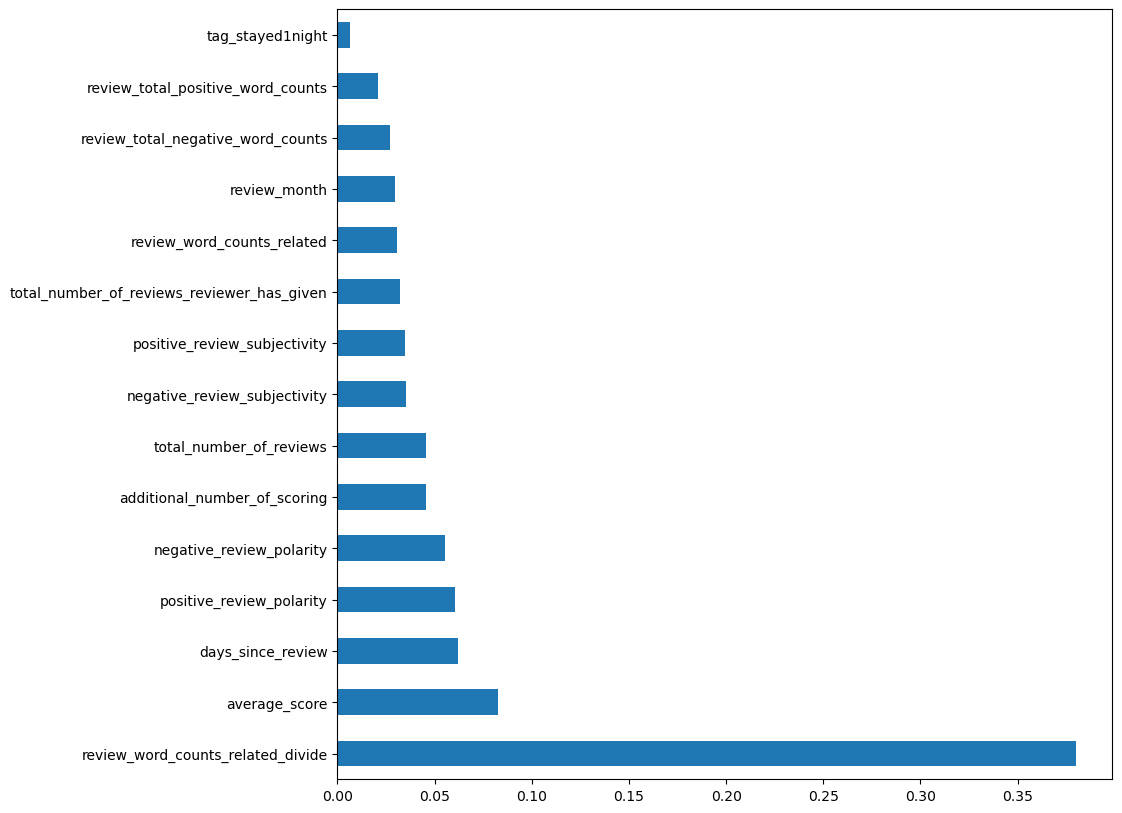

In [48]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

как я хорошо угадал с отношением количества слов!!!! Даже пугает. Может есть в этом что-то неправильное?

## 4. Предсказываем результат тестовых данных и сабмитим результат

In [49]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [50]:
predict_submission = regr.predict(test_data)

In [51]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(5)

,reviewer_score,id
0,8.581,488440
1,7.360,274649
2,8.443,374688
3,9.791,404352
4,9.477,451596
